# Section 6

## Preliminaries

### Data Sources
This repository contains a file named `test_correlation.fits`, which you will need for the excercises in this section. 

## Assignment

Complete the following problems. Use code cells to develop and run any Python code required and Markdown cells to respond to any auxilliary questions that ask you to interpret your results.

### Exercise 1 (AST4031 & AST5031):

In this problem you will construct an approximate p.d.f. for the Pearson, Spearman’s and Kendall’s correlation coefficients using the bootstrap method.

1. The file `test_correlation.fits` contains a sample of $N=200$ pairs $\{x_{i}, y_{i}\}$. Make a plot to visualize the data.
2. Compute the Pearson’s, Spearman’s and Kendall’s correlation coefficients, using functions from the `scipy.stats` module.
    * What is the significance of this correlation i.e. what is the probability that the computed values arise by chance, under the hypothesis that the variables are uncorrelated? Use [_Markdown_](https://www.markdownguide.org) equations and text to show how you arrive at your conclusions and to explain your reasoning.
3. Write a code to resample your dataset with using the _bootstrap_ method. Draw one bootstrap sample for $\{x_{i}, y_{i}\}$. Discuss and show graphically the steps and checks you performed to verify that your bootstrap sample is correct.
4. Draw 1000 bootstrap samples from $\{x_{i}, y_{i}\}$. For each sample, recompute the three estimators of the correlation coefficient from _Step 2_.
5. Plot the bootstrap distribution for the correlation coefficients. Use these distributions to derive confidence intervals for the coefficients.
6. Use the MLE to estimate the best fit parameters of a linear relation (i.e., $y=ax+b$).
7. Augment the previous dataset by adding the following three pairs of outliers: 
\begin{align}
p_1&=(-0.6,-2.1)\\
p_2&=(-0.76,0.92)\\
p_3&=(-2,-5)
\end{align}
   Repeat Steps 3 and 4 using this augmented dataset.  
   * How do the distributions of correlation coefficients change now that we have added these outliers? 
   * Make a plot comparing the bootstrap distributions obtained from the old and the new dataset.

In [1]:
import numpy as np
import numpy.random as nprandom
import scipy.stats as spstats
import scipy.stats.distributions as spdists
import scipy.optimize as spopt

import astropy as ap
import astropy.io.fits as apfits
import astropy.table as aptable

from IPython.core.display import display

import matplotlib.pyplot as mplplot
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Solution
### Load and inspect data

In [2]:
fitsFilePath = 'test_correlation.fits'
fitsFile = apfits.open(fitsFilePath)
fitsFile.info()

Filename: test_correlation.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     14   200R x 3C   [D, D, D]   


The data we require are stored as a 3 column `BinTableHDU` in the FITS file's first extension. We'll use the `astropy.table` module to read the data into a high level data structure.

In [3]:
fitsTable = aptable.Table(fitsFile[1].data)

### Part 1:
Now let's make a preliminary scatter plot of the data. The first and second columns contain $x$, and $y$ coordinates, respectively. The third column contains the error on the $y$ coordinate.

Text(0,0.5,'y')

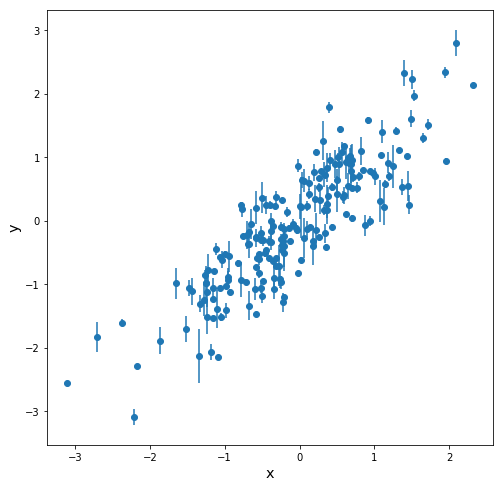

In [4]:
scatterFigure = mplplot.figure(figsize=(8,8))
scatterAxes = scatterFigure.add_subplot(1,1,1)
scatterAxes.errorbar(fitsTable.columns[0], 
                     fitsTable.columns[1], 
                     np.abs(fitsTable.columns[2]), 
                     ls='none', marker='o')
scatterAxes.set_xlabel('x', fontsize='x-large')
scatterAxes.set_ylabel('y', fontsize='x-large')

### Part 2:
To compute the required correlation coefficients, we're told that we can use functions from the [`scipy.stats` module](https://docs.scipy.org/doc/scipy/reference/stats.html#correlation-functions). Specifically, we need the [`pearsonr` ](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr), [`spearmanr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr) and [kendalltau](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html#scipy.stats.kendalltau) functions.

### Exercise 2 (AST5031 Only):

1. Repeat _Step 6_ from _Excercise 1_ but using the augmented file with the outliers. Account for the possibility of having outliers in your definition of the likelihood. 

In [5]:
correlationCoefficients = {
    'Pearson' : spstats.pearsonr(fitsTable.columns[0], fitsTable.columns[1]),
    'Spearman' : spstats.spearmanr(fitsTable.columns[0], fitsTable.columns[1]),
    'Kendal' : spstats.kendalltau(fitsTable.columns[0], fitsTable.columns[1])
}
for name, data in correlationCoefficients.items():
    print('{}: {}'.format(name, data[0]))

Pearson: 0.8660613496851121
Spearman: 0.860888022200555
Kendal: 0.6657286432160804


Now we can compute the significances of the various correlation coefficients.

#### Pearson
In the lectures we saw that for $N$ $(x,y)$ pairs, under a _null hypothesis_ that assumes uncorrelated data, the variable
$$
t(\rho)= \frac{\rho\sqrt{N-2}}{\sqrt{1-\rho^{2}}}
$$
where $\rho$ is the Pearson correlation coefficient, obeys **Student's** $t$ distribution with $\nu=N-2$
$$
f_{S}(t) = \frac{\Gamma \left(\frac{\nu+1}{2} \right)} {\sqrt{\nu\pi}\,\Gamma \left(\frac{\nu}{2} \right)} \left(1+\frac{x^2}{\nu} \right)^{-\frac{\nu+1}{2}}
$$
The required signicance level is then
$$
C = \int\limits_{t=t({\rho^{\star}})}^{\infty}f_{S}(t)~dt
$$
where $\rho^{\star}$ is the computed sample correlation coefficient.

#### Spearman
In the lectures we were told that for uncorrelated variables, and large $N$ (i.e. $N>30$), the distribution of the Spearman correlation coefficient $\rho_{S}$ _also_ obeys **Student's** $t$ distribution with $\nu=N-2$.

The required signicance level is then
$$
C = \int\limits_{t=t({\rho_{S}^{\star}})}^{\infty}f_{S}(t)~dt
$$
where $\rho_{S}^{\star}$ is the computed sample correlation coefficient.

#### Kendall
In the lectures we were told that for uncorrelated variables, and large $N$ (i.e. $N>10$), the distribution of the Kendall $\tau_{K}$ coefficient obeys a **Gaussian** distribution with zero mean and variance
$$
\sigma_{K}^{2}=\frac{2(2N+5)}{9N(N-1)}
$$
The required signicance level is then
$$
C = \int\limits_{\tau=\tau_{K}^{\star}}^{\infty}N(0, \sigma_{K}^{2})~dt
$$
where $\tau_{K}^{\star}$ is the computed sample $\tau$ coefficient.

In [6]:
numCoordPairs = len(fitsTable)

Define the expected _null distributions_ for $t$ and $\tau$. We expect $t$ and $\tau$ to follow the null distributions if $x$ and $y$ are uncorrelated variables.

In [7]:
corrCoeffDists = {
    'Pearson' : spstats.t(df=numCoordPairs-2.0),
    'Spearman' : spstats.t(df=numCoordPairs-2.0),
    'Kendal' : spstats.norm(loc=0, 
                            scale=np.sqrt(
                                2.0*(2.0*numCoordPairs + 5)/(9*numCoordPairs*(numCoordPairs-1))
                            )
                           )
}

Define $\rho \rightarrow t$ transform for Pearson and Spearman coefficients. For Kendall, $\tau$ is used unmodified.

In [8]:
def tForRho(rho, numCoordPairs):
    return rho*np.sqrt((numCoordPairs - 2.0)/(1.0-rho**2.0))

corrCoeffTransforms = {
    'Pearson' : tForRho,
    'Spearman' : tForRho,
    'Kendal' : lambda tau, N: tau
}

Compute the (1-sided) significance levels

In [9]:
def corrCoeffSignifs(correlationCoefficients):
    return {
        name : dist.sf(
            corrCoeffTransforms[name](
                correlationCoefficients[name][0], 
                numCoordPairs
            )
        ) for name, dist in corrCoeffDists.items()
    }

Print the significance levels and compare with the 2-sided intervals returned by scipy

In [10]:
for name, significance in corrCoeffSignifs(correlationCoefficients).items():
    print('{}: {} (scipy: {})'.format(name, significance, 0.5*correlationCoefficients[name][1]))

Pearson: 7.927050090950623e-62 (scipy: 7.92705009095054e-62)
Spearman: 2.5805900597199066e-60 (scipy: 2.5805900597199066e-60)
Kendal: 7.830782633516234e-45 (scipy: 7.830782633516234e-45)


The significance levels indicate that correlation coefficients _greater than or equal_ to those that we that we obtained is _extremely_ unlikely for uncorrelated data. The data are strongly correlated.

### Part 3
The bootstrap method entails sampling **with replacement** from the original dataset. We need to maintain the correspondence between the coordinate pairs (and errors) when sampling. Practically, this means that we are sampling whole rows from the data table.

Since we're sampling **with replacement**, an efficient way to do that is to generate a random set of row indices and form a new table using the rows that correspond to those indices.

We can use the `numpy.random.randint function` to do generate the indices that we require. We'll define a function to generate bootstrap samples with arbitrary size.

In [11]:
def bootstrapSample(inputDataTable, numSamples):
    randomIndices = nprandom.randint(0, len(inputDataTable), numSamples)
    return inputDataTable[randomIndices]

Yes! It really is that simple! Now let's make some plots to verify that our bootstrapped distributions are statistically consistent with the original data.

We'll make a two-dimensional scatter plot of the the $x$ and $y$ coordinates for a few datasets and histograms to show the distributions for $x$ and $y$ independently.

In [12]:
def plotBootstrappedTables(bootstrappedTables):
    bootstrapFigure, bootstrapSubplots = mplplot.subplots(figsize=(10,10), 
                                                          ncols=2, nrows=2, 
                                                          gridspec_kw=dict(
                                                              width_ratios=(8,2), 
                                                              height_ratios=(2,8),
                                                              hspace=0, wspace=0
                                                          )
                                                         )
    bootstrapScatterAxes = bootstrapSubplots[1,0]
    bootStrapYHistAxes = bootstrapSubplots[1,1]
    bootStrapXHistAxes = bootstrapSubplots[0,0]
    bootstrapSubplots[0,1].axis('off')

    bootStrapYHistAxes.set_xlabel('Sample Count', fontsize='x-large')
    bootStrapXHistAxes.set_ylabel('Sample Count', fontsize='x-large')

    bootstrapScatterAxes.set_xlabel('x', fontsize='x-large')
    bootstrapScatterAxes.set_ylabel('y', fontsize='x-large')

    for counter, bootstrappedTable in enumerate(bootstrappedTables):
        ## Plot a 2D scatter plot of the bootstrapped dataset
        bootstrapScatterAxes.errorbar(bootstrappedTable.columns[0], 
                                      bootstrappedTable.columns[1], 
                                      np.abs(bootstrappedTable.columns[2]), 
                                      ls='none', marker='o', ms=4, 
                                      label='Sample {}'.format(counter + 1))
        ## Plot marginal histograms of the separate coordinate variables for the bootstrapped dataset
        bootStrapYHistAxes.hist(bootstrappedTable.columns[1], orientation='horizontal', 
                                histtype='step', bins=20, label=None)
        bootStrapXHistAxes.hist(bootstrappedTable.columns[0], histtype='step', bins=20, 
                                label=None)
        bootStrapYHistAxes.set_ylim(*bootstrapScatterAxes.get_ylim())
        bootStrapXHistAxes.set_xlim(*bootstrapScatterAxes.get_xlim())

    ## Plot marginal histograms of the separate coordinate variables for the original dataset
    bootStrapXHistAxes.hist(fitsTable.columns[0], histtype='step', bins=20, 
                            lw=3, ec='k', label='Original Data')
    bootStrapYHistAxes.hist(fitsTable.columns[1], orientation='horizontal', 
                            histtype='step', bins=20, lw=3, ec='k',
                            label=None)

    bootstrapScatterAxes.legend(fontsize='x-large')
    bootStrapXHistAxes.legend(fontsize='x-large')

    mplplot.tight_layout()

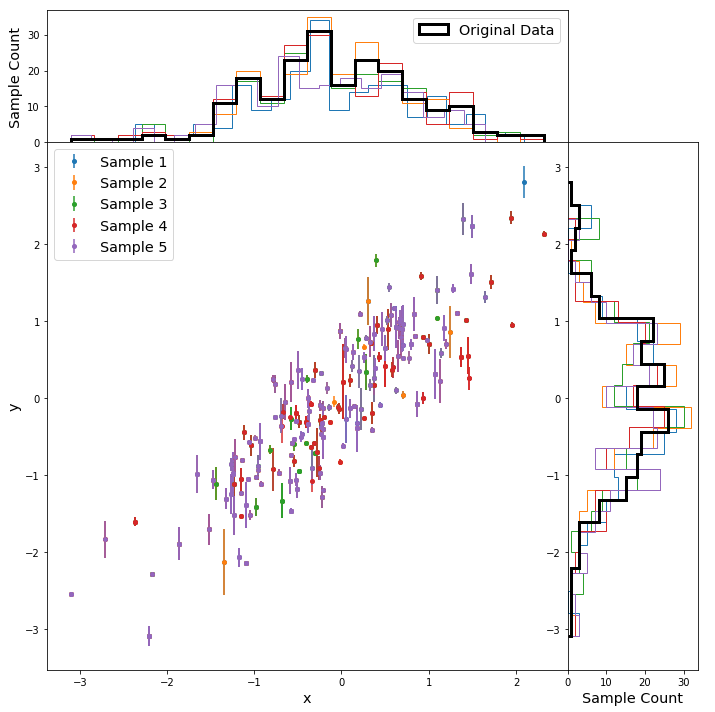

In [13]:
bootstrappedTables = [bootstrapSample(fitsTable, 200) for _ in range(5)]
plotBootstrappedTables(bootstrappedTables)

Our original data were also strongly correlated. We should verify that the same is true for our bootstrapped samples. We'll write a function to combine some of the code we developed earlier and improve its reusability.

In [14]:
def computeCorrelationCoefficients(fitsTable):
    spstatsResults = {
        'Pearson' : spstats.pearsonr(fitsTable.columns[0], fitsTable.columns[1]),
        'Spearman' : spstats.spearmanr(fitsTable.columns[0], fitsTable.columns[1]),
        'Kendal' : spstats.kendalltau(fitsTable.columns[0], fitsTable.columns[1])
    }
    correlationCoefficients = np.array([spstatsResult[0] for spstatsResult in spstatsResults.values()])
    twoSidedProbs = np.array([spstatsResult[1] for spstatsResult in spstatsResults.values()])
    names = list(spstatsResults.keys())
    return correlationCoefficients, twoSidedProbs, names

Now let's compute all correlation coefficent variants for each of our bootstrap samples. As a pedagogical example, we'll construct an `astropy.table.Table` data structure to store the results. Knowing how to do this will make adding outliers to our original data table easier later.

It's probably worth quoting this note from the [`astropy.table.Table` documentation](http://docs.astropy.org/en/stable/table/construct_table.html).
> Adding rows requires making a new copy of the entire table each time, so in the case of large tables this may be slow. On the other hand, adding columns is reasonably fast.

For our purposes we don't need to worry about performance impact, but it's good to be aware of this caveat.

In [15]:
origCorrCoeffs, _ , origNames = computeCorrelationCoefficients(fitsTable)

corrCoeffTable = aptable.Table(names=['DataSet'] + origNames, dtype=['S10'] + ['f8']*len(origCorrCoeffs))
corrCoeffTable.add_row(('Original', *origCorrCoeffs))

for bootstrappedTableCounter, bootstrappedTable in enumerate(bootstrappedTables):
    corrCoeffs, _, _ = computeCorrelationCoefficients(bootstrappedTable)
    corrCoeffTable.add_row(('Sample {}'.format(bootstrappedTableCounter+1), *corrCoeffs))
    
display(corrCoeffTable)

DataSet,Pearson,Spearman,Kendal
bytes10,float64,float64,float64
Original,0.8660613496851121,0.860888022200555,0.6657286432160804
Sample 1,0.8653370708013466,0.8500272284988619,0.6565656565656567
Sample 2,0.8571661801667104,0.8451747141852047,0.6478837713766835
Sample 3,0.9031169234860619,0.9053516833334833,0.7258821747690444
Sample 4,0.8572026087214257,0.8366247217171626,0.6356475637465288
Sample 5,0.8841907662869667,0.8777843118429265,0.6880585710679122


Looks like all our bootstrap samples have correlation coefficients that are comparable with the original dataset. It looks like our bootstrapping code is functioning effectively! 

### Part 4
We can write a simple function that efficiently accomplishes the bootstrap sampling and correlation coefficient computation before returning a two dimensional `numpy.array` containing the three correlation coefficient variants for every bootstrap sample.

In [16]:
def bootstrapCorrCoeffs(numSamplings, fitsTable):
    coefficients = np.array(
        [
            list(
                computeCorrelationCoefficients(
                    bootstrapSample(fitsTable, 
                                    len(fitsTable)
                                   )
                )[0]
            ) for _ in range(1000)
        ]
    )
    return coefficients.T

bootstrapCorrCoeffSamples = bootstrapCorrCoeffs(1000, fitsTable)

### Part 5
We'll write a simple function to compute arbitrary confidence intervals and overplot them on the bootstrap distributions for each coefficient.

In [17]:
def plotCorrCoeffConfidenceIntervals(bootstrapCorrCoeffSamples, confLevel = 68, titleSuffix=''):
    bootstrapCorrCoeffDistFigShape = np.array([bootstrapCorrCoeffSamples.shape[0], 1])
    bootstrapCorrCoeffDistFig, bootstrapCorrCoeffDistPanels = mplplot.subplots(figsize=bootstrapCorrCoeffDistFigShape*4,
                                                                               nrows=bootstrapCorrCoeffDistFigShape[1],
                                                                               ncols=bootstrapCorrCoeffDistFigShape[0])

    for sampleCounter, (sample, panel, label) in enumerate(zip(bootstrapCorrCoeffSamples, 
                                                               bootstrapCorrCoeffDistPanels.flatten(),
                                                               [r'$\rho$', r'$\rho_{\mathrm{S}}$', r'$\tau$'])):
        percentiles = [0.5*(100.0-confLevel), 100-0.5*(100.0-confLevel)]
        confidenceIntervals = np.percentile(a=sample, q=percentiles)
        panel.hist(sample, bins=100)
        for percentileCounter, (confidenceInterval, percentile) in enumerate(zip(confidenceIntervals, percentiles)):
            panel.axvline(confidenceInterval, ls='--', 
                          c='C{}'.format(percentileCounter+1),
                          label='{:d}%: {:.2f}'.format(int(percentile), confidenceInterval))

        panel.set_xlabel(label, fontsize='x-large')
        panel.legend(title='Confidence Interval')
    bootstrapCorrCoeffDistFig.suptitle('Correlation Coefficient Bootstrap Distributions {}'.format(titleSuffix), 
                                       y=1.05)

    mplplot.tight_layout()

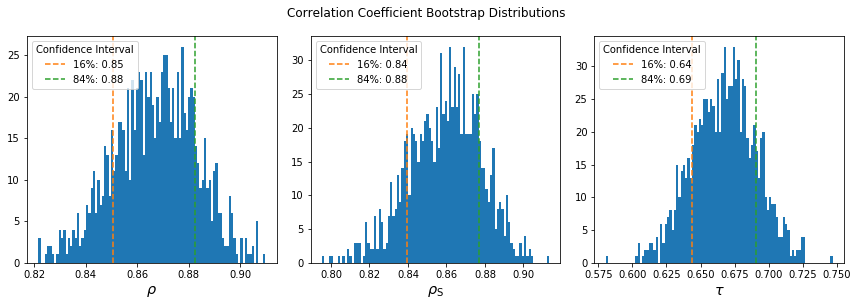

In [18]:
plotCorrCoeffConfidenceIntervals(bootstrapCorrCoeffSamples)

### Part 6:
The question instructs us to fit a linear model to the data.
$$
y = ax+b
$$
To construct a likelihood model we need also to adopt a reasonable model for the data arrors, $\delta_{y}$. Let's plot them to get an idea of their distribution.

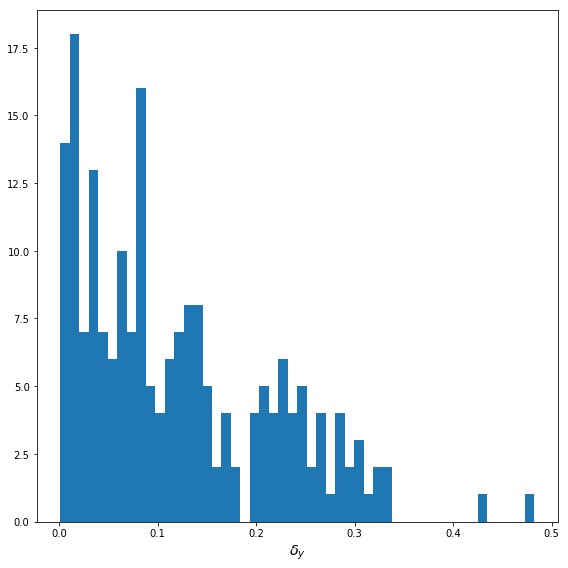

In [19]:
errorDistAxes = mplplot.figure(figsize=(8,8)).add_subplot(1,1,1)
errorDistAxes.hist(np.abs(fitsTable.columns[2]), bins=50)
errorDistAxes.set_xlabel('$\delta_{y}$', fontsize='x-large')
mplplot.tight_layout()

A model that assumes _Gaussian_ distributed errors seems reasonable, so we'll model each of our observations as a random sample from a Gaussian PDF, with mean equal to the expected model value (i.e. $\mu=ax_{i} + b$) and standard deviation equal to measurement error $\sigma=\delta_{y}^{i}$. The full likelihood is simply the product over all $N$ observations
$$
\mathcal{L} = \displaystyle\prod\limits_{i=1}^{N}\frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{\left[y_{i} - (ax_{i}+b)\right]^{2}}{{2\delta_{y}^{i}}^{2}}\right)
$$
Using a similar approach to that used in the solution of _Section 5_, we'll use the `scipy.optimize.minimize` function to minimize the _negative log-likelihood_. Taking the natural logarithm of the previous expression and simplifying yields
$$
-\ln\mathcal{L} = \mathrm{constant} + \frac{1}{2}\displaystyle\sum\limits_{i}\frac{\left[y_{i} - (ax_{i} +b)\right]^{2}}{{\delta_{y}^{i}}^2}
$$
Let's write some functions to compute this quantity. The final one (`spLogLikelihood`) is simply a wrapper that has the signature required by the [`scipy.optimize.minimize` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).

In [20]:
def linearPolynomial(x, a, b):
    return a*x + b

def logLikelihood(x, y, deltaY, a, b):
    # ignore the factor of 0.5
    return np.sum(((y - linearPolynomial(x, a, b))/deltaY)**2.0)

def spLogLikelihood(aAndB, x, y, deltaY):
    return logLikelihood(x, y, deltaY, *aAndB)

Now we can run the minimizer to find the best fitting values for $a$ and $b$. The simplicity of the function we're fitting means that the parameter values we pick for our initial guess (`x0`) should have very little impact, we'll just set both to zero.

We can get some insight into the operation of the minimizer by passing a _callback function_ that we can use to record the parameter values for which the mimimizer computes the likelihood and investigate it's prgress later. The callback should accept the current parameter vector as its first argument. For some solvers a [`scipy.optimize.OptimizeResult` instance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult) is provided as a second argument to the callback.

We'll also specify that the minimizer use the [Nelder-Mead solver](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html#optimize-minimize-neldermead), which is likely to converge more reliably than the default [BFGS solver](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html#optimize-minimize-bfgs) for this task. 

Result of Minimization:
 final_simplex: (array([[0.78872743, 0.01910661],
       [0.78872811, 0.01909892],
       [0.78874314, 0.01910832]]), array([177260.96164323, 177260.96165484, 177260.96173373]))
           fun: 177260.96164322903
       message: 'Optimization terminated successfully.'
          nfev: 126
           nit: 65
        status: 0
       success: True
             x: array([0.78872743, 0.01910661])


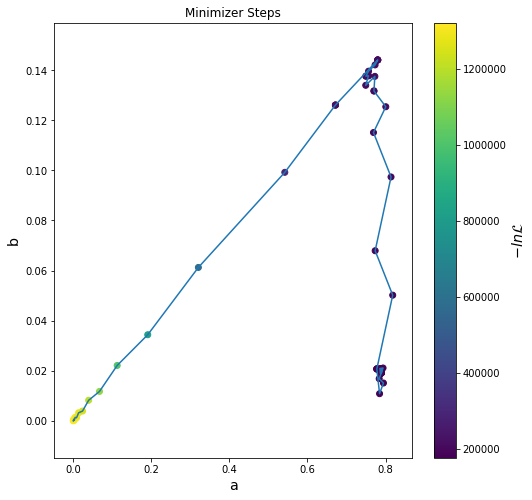

In [21]:
## Store a list of trial parameter values that the minimizer visits
## Initialize the first element with our starting guess.
trailParameterList = [[0.0, 0.0]]

## Callback function to record the parameter values that the minimizer visits
def recorderCallback(currentParameters):
    trailParameterList.append(currentParameters)

## Run the minimizer.
minimizationResult = spopt.minimize(fun=spLogLikelihood, 
                                    x0=trailParameterList[0], 
                                    args=(fitsTable.columns[0], 
                                          fitsTable.columns[1], 
                                          np.abs(fitsTable.columns[2])), 
                                    callback=recorderCallback, 
                                    method = 'Nelder-Mead')

## Examine the minimizer output to evaluate the success of the fit.
print('Result of Minimization:', minimizationResult, sep='\n')

def plotMinimizationProcess(trailParameterList, logLikelihoodFunction, dataTable):
    ## Plot the likelihood curves for the model parameters
    parLikeFigure = mplplot.figure(figsize=(8,8))
    parLikeAxes = parLikeFigure.add_subplot(1,1,1)
    scatterPlot = parLikeAxes.scatter(np.asarray(trailParameterList)[:,0], 
                                      np.asarray(trailParameterList)[:,1], 
                                      c=[logLikelihoodFunction(trailParameterPair, 
                                                               dataTable.columns[0], 
                                                               dataTable.columns[1], 
                                                               np.abs(dataTable.columns[2])
                                                              ) for trailParameterPair in trailParameterList],
                                     )

    parLikeAxes.plot(np.asarray(trailParameterList)[:,0], 
                     np.asarray(trailParameterList)[:,1])

    parLikeAxes.set_xlabel('a', fontsize='x-large')
    parLikeAxes.set_ylabel('b', fontsize='x-large')
    parLikeAxes.set_title('Minimizer Steps')

    colourbar = mplplot.colorbar(scatterPlot, ax=parLikeAxes)
    colourbar.set_label('$-ln\mathcal{L}$', fontsize='x-large')
    
plotMinimizationProcess(trailParameterList, spLogLikelihood, fitsTable)

Note that the mimimzer converged after 126 function evaluations. This is orders of magnitude more efficient than trying to find the minimum using a grid search. Now let's plot the best fitting linear function over the data.

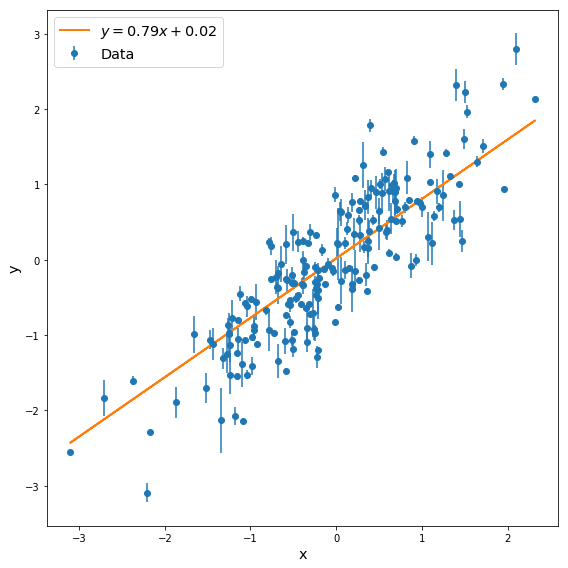

In [22]:
mleFigure = mplplot.figure(figsize=(8,8))
mleAxes = mleFigure.add_subplot(1,1,1)
mleAxes.errorbar(fitsTable.columns[0], fitsTable.columns[1], yerr=np.abs(fitsTable.columns[2]), 
                 ls='none', marker='o', label='Data')
mleAxes.plot(fitsTable.columns[0], linearPolynomial(fitsTable.columns[0], *minimizationResult.x), 
             label='$y={:.2f}x+{:.2f}$'.format(*minimizationResult.x), lw=2)
mleAxes.set_xlabel('x', fontsize='x-large')
mleAxes.set_ylabel('y', fontsize='x-large')
mleAxes.legend(fontsize='x-large')
mplplot.tight_layout()

### Part 7:
We can use the same `add_row` method of `astropy.table.Table` to insert the outlier points into our dataset. We'll also generate errors for the new points that are consistent with the observed distribution of point errors.

Let's find the standard deviation of the distribution of measurement errors, then draw three values from a Gaussian distribution with that standard deviation and zero mean.

In [23]:
errorStDev = np.std(fitsTable.columns[2])
newErrors = np.abs(nprandom.normal(loc=0, scale=errorStDev, size=3))
print(newErrors)

[0.13592967 0.24712055 0.03428665]


Now we're ready to add three new outlier rows to out data table. We'll make a copy of the original to add the outliers to.

In [24]:
outlierCoordPairs =[(-0.6,-2.1),
                    (-0.76,0.92),
                    (-2,-5)]

outlierTable = fitsTable.copy()

for (x, y), deltaY in zip(outlierCoordPairs, newErrors):
    outlierTable.add_row((x,y,deltaY))

Now let's replot the data with outliers.

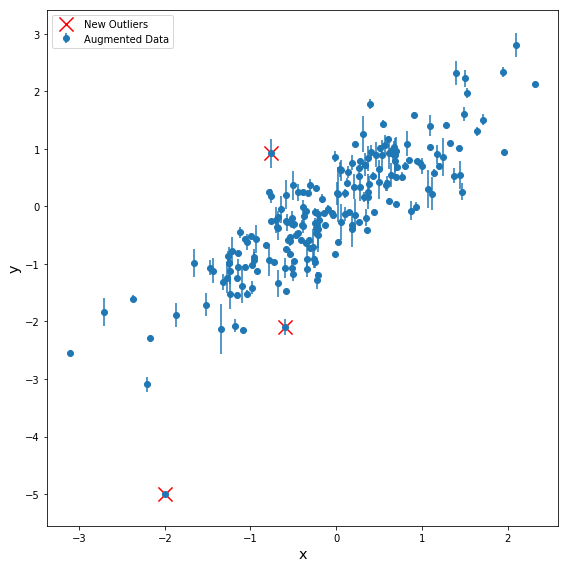

In [25]:
outlierScatterFigure = mplplot.figure(figsize=(8,8))
outlierScatterAxes = outlierScatterFigure.add_subplot(1,1,1)
outlierScatterAxes.errorbar(outlierTable.columns[0], 
                            outlierTable.columns[1], 
                            np.abs(outlierTable.columns[2]), 
                            ls='none', marker='o', label='Augmented Data')
outlierScatterAxes.scatter(outlierTable.columns[0][-3:], outlierTable.columns[1][-3:], 
                           marker='x', label='New Outliers', c='r', s=200)
outlierScatterAxes.set_xlabel('x', fontsize='x-large')
outlierScatterAxes.set_ylabel('y', fontsize='x-large')
outlierScatterAxes.legend()
mplplot.tight_layout()

We can reuse the code we wrote for _Part 3_ and _Part 4_ and apply it to the augmented dataset. Note that since we only added three outliers, the chance that any of them will be chosen in any given bootstrap sample is small.

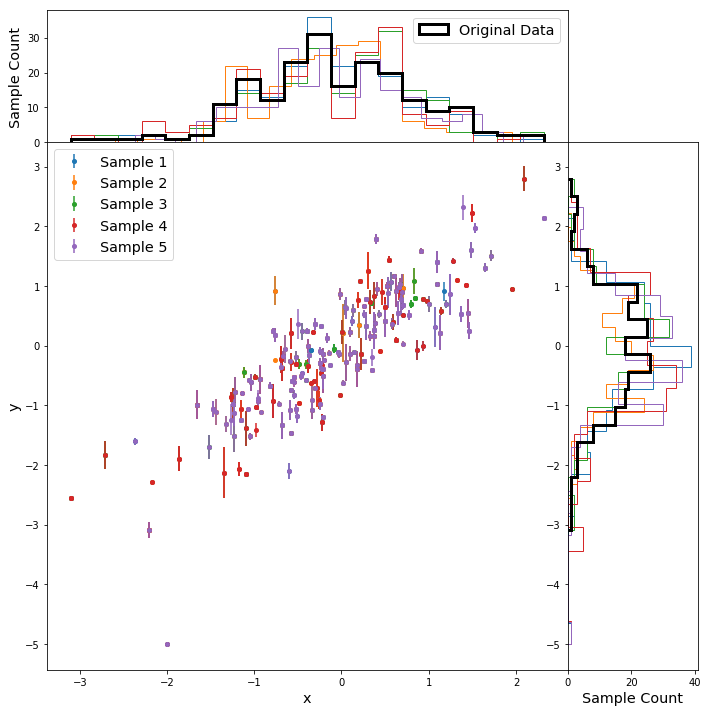

In [26]:
bootstrappedOutlierTables = [bootstrapSample(outlierTable, 200) for _ in range(5)]
plotBootstrappedTables(bootstrappedOutlierTables)

Now we can generate a large number of bootstrap samples for the augmeneted dataset.

In [27]:
bootstrapOutlierCorrCoeffSamples = bootstrapCorrCoeffs(1000, outlierTable)

We'll plot the correleation coefficient distributions for the original sample and the augmented sample so we can compare them

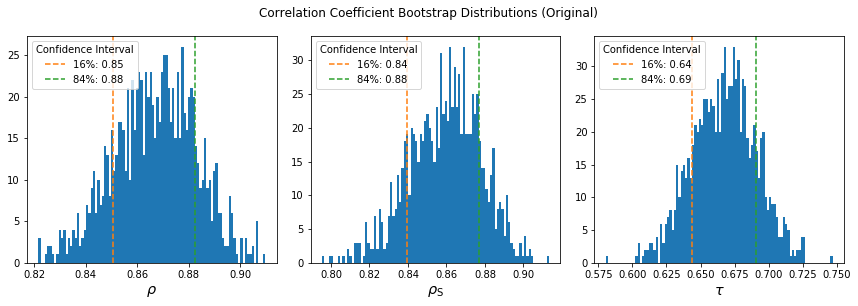

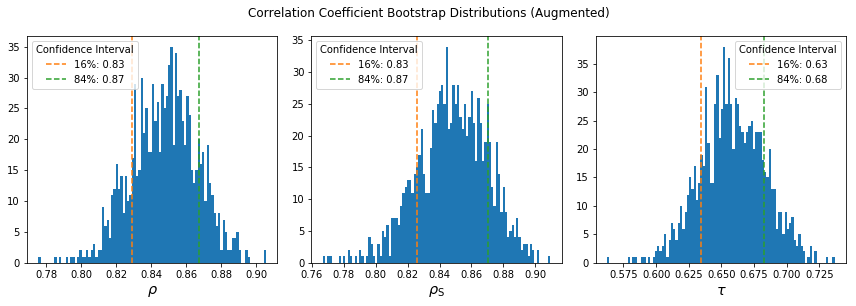

In [28]:
plotCorrCoeffConfidenceIntervals(bootstrapCorrCoeffSamples, titleSuffix='(Original)')
plotCorrCoeffConfidenceIntervals(bootstrapOutlierCorrCoeffSamples, titleSuffix='(Augmented)')

Although all the coefficients are mildly affected by the addition of outliers, the _Pearson_ $\rho$ coefficient is most strongly affected. This is to be expected since it depends on the **values** of the outlier data, while $\rho_{\mathrm{S}}$ and $\tau$ depend only on the rank ordering, which makes them more robust against outliers.

### Exercise 2 (AST5031 Only):

1. Repeat _Step 6_ from _Excercise 1_ but using the augmented file with the outliers. Account for the possibility of having outliers in your definition of the likelihood. 

## Solution
### Part 1
To solve this problem we can use a similar approach to that used to treat contaminant galaxies in the assignment for _Section 6_. Recall that in that case, we modeled the contaminants using a uniform distribution of galaxy velocities. 

In this case we can assume that the outliers measurements represent a separate population of objects to those in the main sample. Since we are almost completely ignorant regarding the distribution of this outlier population, a uniform model is appropriate this time as well. Specifically, we can add a uniformly distributed component to our likelihood model. We'll assume that the allowable range of outlier measurements is twice as large as the range of measurements in the original sample and centred at the original sample mean. Practically, this range might represent the sensitive range of the measurement instrument, so values outside this range would be impossible.
$$
\mathcal{L} = \displaystyle\prod\limits_{i=1}^{N}\eta\cdot\mathcal{U} + \frac{(1-\eta)}{\sqrt{2\pi}\sigma}\exp\left(-\frac{\left[y_{i} - (ax_{i}+b)\right]^{2}}{{2\delta_{y}^{i}}^{2}}\right)
$$
So the negative log-likelihood is simply
$$
-\ln\mathcal{L} = -\displaystyle\sum\limits_{i=1}^{N}\ln\left[\eta\cdot\mathcal{U} + \frac{(1-\eta)}{\sqrt{2\pi}\sigma}\exp\left(-\frac{\left[y_{i} - (ax_{i}+b)\right]^{2}}{{2\delta_{y}^{i}}^{2}}\right)\right]
$$ 

In [29]:
def uniform(y, minY, maxY):
    return np.where((y > minY) & (y < maxY), 1.0/(maxY - minY), 0.0)

def gaussian(y, mu, sigma):
    return np.exp(-0.5*((y-mu)/sigma)**2)/(np.sqrt(2.0*np.pi)*sigma)

def spLogLikelihoodWithOutliers(parameters, x, y, deltaY):
    a, b, eta = parameters
    mu = linearPolynomial(x=x, a=a, b=b)
    outlierRange = (y.mean() - 2.0*(y.mean() - y.min()), y.mean() + 2.0*(y.max() - y.mean()))
    likelihood = eta*uniform(y, *outlierRange) + (1.0-eta)*gaussian(y, mu, deltaY)
    return -np.sum(np.log(likelihood[likelihood > 0]))

Let's run the minimizer using the augmented data and our new likelihood model. We'll use $\eta=0.1$ as our initial guess for the outlier fraction.

In [30]:
trailParameterListWithOutliers = [[*minimizationResult.x, 0.1]]

## Callback function to record the parameter values that the minimizer visits
def recorderCallbackWithOutliers(currentParameters):
    trailParameterListWithOutliers.append(currentParameters)

## Run the minimizer.
minimizationResultWithOutliers = spopt.minimize(fun=spLogLikelihoodWithOutliers, 
                                                x0=trailParameterListWithOutliers[0], 
                                                args=(outlierTable.columns[0], 
                                                      outlierTable.columns[1], 
                                                      np.abs(outlierTable.columns[2])),
                                                callback=recorderCallbackWithOutliers, 
                                                method='Nelder-Mead')

## Examine the minimizer output to evaluate the success of the fit.
print('Result of Minimization:', minimizationResultWithOutliers, sep='\n')

Result of Minimization:
 final_simplex: (array([[ 0.87553923, -0.05906948,  0.60585852],
       [ 0.87552054, -0.05908522,  0.60593577],
       [ 0.87552304, -0.05907913,  0.60581173],
       [ 0.87553655, -0.05909436,  0.60591176]]), array([427.56276455, 427.56276631, 427.56276879, 427.56276918]))
           fun: 427.5627645487667
       message: 'Optimization terminated successfully.'
          nfev: 165
           nit: 89
        status: 0
       success: True
             x: array([ 0.87553923, -0.05906948,  0.60585852])


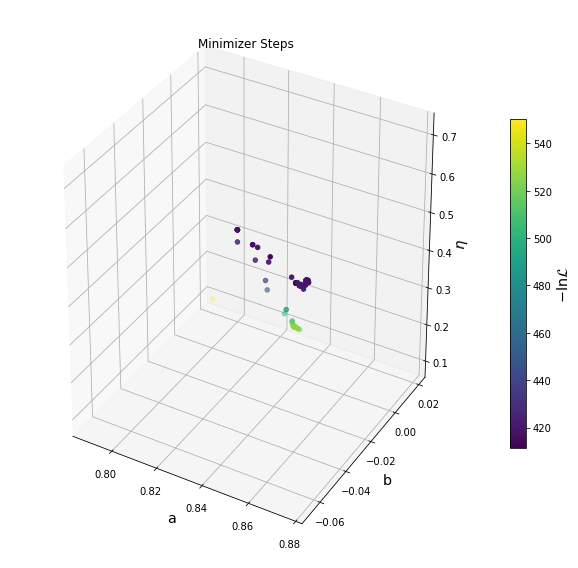

In [31]:
mimizerProgressFigure = mplplot.figure(figsize=(8.5,8))
mimizerProgressAxes = mimizerProgressFigure.add_subplot(1,1,1, projection='3d')
trailParameterArrayWithOutliers = np.array(trailParameterListWithOutliers)
scatter3d = mimizerProgressAxes.scatter(xs=trailParameterArrayWithOutliers[:, 0], 
                            ys=trailParameterArrayWithOutliers[:, 1], 
                            zs=trailParameterArrayWithOutliers[:, 2],
                           c = [spLogLikelihoodWithOutliers(trailParameters,outlierTable.columns[0], 
                                                      outlierTable.columns[1], 
                                                      outlierTable.columns[2]) for trailParameters in trailParameterArrayWithOutliers])

mimizerProgressAxes.set_xlabel('a', fontsize='x-large')
mimizerProgressAxes.set_ylabel('b', fontsize='x-large')
mimizerProgressAxes.set_zlabel('$\eta$', fontsize='x-large')

mimizerProgressAxes.set_title('Minimizer Steps')

colourBarWithOutliers = mplplot.colorbar(scatter3d, ax = mimizerProgressAxes, shrink=0.6)
colourBarWithOutliers.set_label('$-\ln\mathcal{L}$', fontsize='x-large')
mplplot.tight_layout()

Let's also try a fit using our original likelihood function.

In [32]:
## Run the minimizer.
minimizationResultWithOutliersOldLL = spopt.minimize(fun=spLogLikelihood, 
                                                     x0=trailParameterList[0], 
                                                     args=(outlierTable.columns[0], 
                                                           outlierTable.columns[1], 
                                                           np.abs(outlierTable.columns[2])), 
                                                     callback=recorderCallback, 
                                                     method = 'Nelder-Mead')

## Examine the minimizer output to evaluate the success of the fit.
print('Result of Minimization:', minimizationResultWithOutliersOldLL, sep='\n')

Result of Minimization:
 final_simplex: (array([[0.79203033, 0.01742601],
       [0.79202944, 0.01743406],
       [0.79203747, 0.01742995]]), array([187495.80134275, 187495.80137311, 187495.80139549]))
           fun: 187495.80134274697
       message: 'Optimization terminated successfully.'
          nfev: 119
           nit: 62
        status: 0
       success: True
             x: array([0.79203033, 0.01742601])


Finally, let's plot both fit results together with the data.

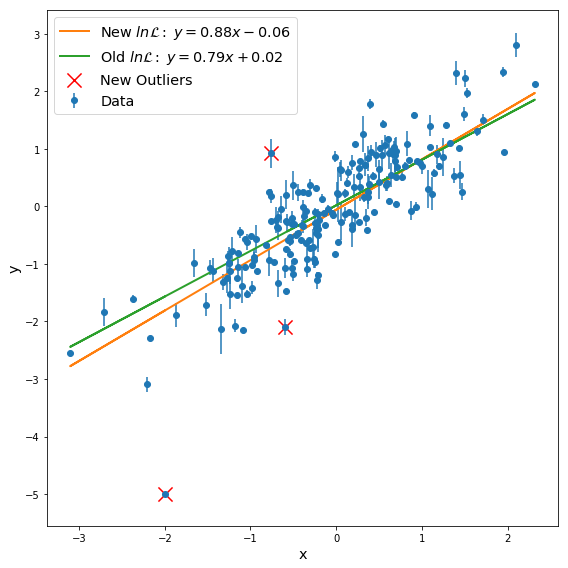

In [33]:
mleOutlierFigure = mplplot.figure(figsize=(8,8))
mleOutlierAxes = mleOutlierFigure.add_subplot(1,1,1)
mleOutlierAxes.errorbar(outlierTable.columns[0], 
                        outlierTable.columns[1], 
                        yerr=np.abs(outlierTable.columns[2]), 
                        ls='none', marker='o', label='Data')
mleOutlierAxes.scatter(outlierTable.columns[0][-3:], outlierTable.columns[1][-3:], 
                       marker='x', label='New Outliers', c='r', s=200)
mleOutlierAxes.plot(outlierTable.columns[0], 
                    linearPolynomial(outlierTable.columns[0], 
                                     *minimizationResultWithOutliers.x[:-1]), 
                    label='New $ln\mathcal{{L}}:\;y={:.2f}x{:+.2f}$'.format(*minimizationResultWithOutliers.x[:-1]), 
                    lw=2)
mleOutlierAxes.plot(outlierTable.columns[0], 
                    linearPolynomial(outlierTable.columns[0], 
                                     *minimizationResultWithOutliersOldLL.x), 
                    label='Old $ln\mathcal{{L}}:\;y={:.2f}x{:+.2f}$'.format(*minimizationResultWithOutliersOldLL.x), 
                    lw=2)
mleOutlierAxes.set_xlabel('x', fontsize='x-large')
mleOutlierAxes.set_ylabel('y', fontsize='x-large')
mleOutlierAxes.legend(fontsize='x-large')
mplplot.tight_layout()

The outlier bias the fit result using the original formulation of $\ln\mathcal{L}$, but the new formulation is robust against its influence, we can check this by plotting the residuals between the best fit model and the data.

In [34]:
def plotResiduals(x, y, deltaY, modelFunction, modelParameters, title, numOutliers=3):
    residualFigure, residualPanels = mplplot.subplots(figsize=(8, 4), nrows=1, ncols=2, 
                                                      gridspec_kw=dict(
                                                          width_ratios=[6,2], 
                                                          wspace=0
                                                      )
                                                     )
    residuals = y - modelFunction(x, *modelParameters)
    
    residualFitResult = np.polyfit(x=x[:-numOutliers], y=residuals[:-numOutliers], deg=1)
    
    residualPanels[0].errorbar(x, residuals, yerr=deltaY, ls='none', marker='o', label=None)
    residualPanels[0].scatter(x[-numOutliers:], residuals[-numOutliers:], marker='x', s=100, c='r', label='Outliers')

    residualPanels[0].plot(x, residualFitResult[0]+residualFitResult[1]*x, 
                           label='$\delta y={:.2f}x{:+.2f}$'.format(*np.flipud(residualFitResult)))
    
    _, bins, _ = residualPanels[1].hist(residuals, bins=30, orientation='horizontal')
    residualPanels[1].hist(residuals[-numOutliers:], bins=bins, 
                           orientation='horizontal', histtype='step', 
                           ec='r')

    residualPanels[1].set_ylim(*residualPanels[0].get_ylim())
    residualPanels[1].set_yticklabels([])
    
    residualPanels[0].axhline(y=0, ls='--', c='k')
    residualPanels[1].axhline(y=0, ls='--', c='k')
    
    residualPanels[0].set_ylabel('$y - ax + b$', fontsize='x-large')
    residualPanels[0].set_xlabel('$x$', fontsize='x-large')
    residualPanels[1].set_xlabel('Count', fontsize='x-large')
    
    residualPanels[0].legend(fontsize='medium')
    
    residualFigure.suptitle(title, fontsize='x-large', y=1.05)
    mplplot.tight_layout()

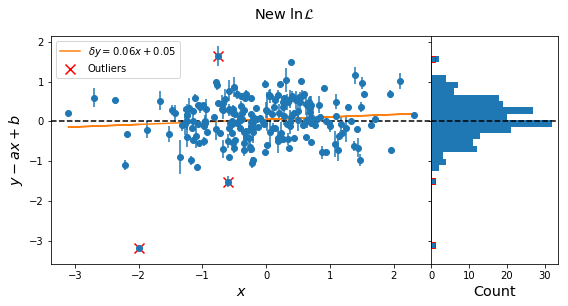

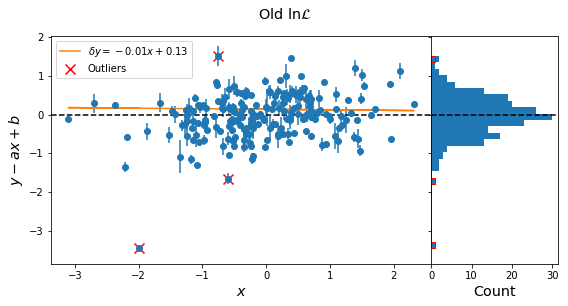

In [35]:
plotResiduals(x=outlierTable.columns[0], 
              y=outlierTable.columns[1], 
              deltaY=np.abs(outlierTable.columns[2]), 
              modelFunction=linearPolynomial, 
              modelParameters=minimizationResultWithOutliers.x[:-1], 
              title='New $\ln\mathcal{L}$')

plotResiduals(x=outlierTable.columns[0], 
              y=outlierTable.columns[1], 
              deltaY=np.abs(outlierTable.columns[2]), 
              modelFunction=linearPolynomial, 
              modelParameters=minimizationResultWithOutliersOldLL.x, 
              title='Old $\ln\mathcal{L}$')

The plots conform that the residual distribution is biased above zero for the old formulation of $\ln\mathcal{L}$ but not for the new formulation.